In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.utils import plot_model
from keras.layers import LSTM, Dense
from keras.layers import Activation, Flatten, Dropout, Concatenate
from keras.optimizers import SGD
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [4]:
new_df = df.filter(train_cols, axis=1)

In [5]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [26]:
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    output_size_1 = Y.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,output_size_1))
    Y_values_actual = np.zeros((input_size_0,output_size_1))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1]
        Y_values_actual[i] = Y_actual[time_steps+i-1]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [7]:
lag_df = lag_seq(new_df, 2)
lag_df.dropna(inplace=True)

In [8]:
lag_df

,Precipitation,Temperature,Outflow,Outflow(t+1),Outflow(t+2)
0,0.0,102.992,5.0,5.0,5.0
1,0.0,97.790,5.0,5.0,5.0
2,0.0,92.588,5.0,5.0,5.0
3,0.0,87.404,5.0,5.0,5.0
4,0.0,85.172,5.0,5.0,5.0
...,...,...,...,...,...
185537,0.0,50.054,27.0,29.0,30.0
185538,0.0,52.880,29.0,30.0,29.0
185539,0.0,54.284,30.0,29.0,29.0
185540,0.0,55.670,29.0,29.0,31.0


In [9]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ["Outflow(t+1)","Outflow(t+2)"]

In [10]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [11]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [12]:
x_train.shape, y_test.shape

((148433, 3), (37109, 2))

In [13]:
y_train_actual = y_train
y_test_actual = y_test

In [25]:
y_train.shape[1]

2

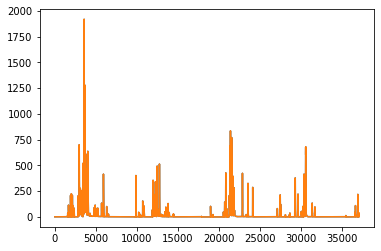

In [14]:
plt.figure()
plt.plot(y_test_actual)
plt.show()

In [15]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

In [24]:
y_train_actual[4]

array([5., 5.])

In [27]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (148415, 18, 3) (148415, 2)



length of time-series i/o (37091, 18, 3) (37091, 2)


In [28]:
X_Train.shape,Y_Train.shape

((148415, 18, 3), (148415, 2))

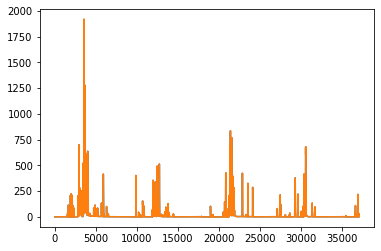

In [29]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [31]:
#Build Model
inp = Input(shape=(18, 3), name = 'inp')
#build modelA
lstm1A = LSTM(units=24, return_sequences=True, 
               name = 'lstm1A')(inp)
do1A = Dropout(0.2, name = 'do1A')(lstm1A)
lstm2A = LSTM(units=50, name = 'lstm2A')(do1A)
do2A = Dropout(0.2, name = 'do2A')(lstm2A)

#build modelB
lstm1B = LSTM(units=24, return_sequences=True, 
               name = 'lstm1B')(inp)
do1B = Dropout(0.2, name = 'do1B')(lstm1B)
lstm2B = LSTM(units=50, name = 'lstm2B')(do1B)
do2B = Dropout(0.2, name = 'do2B')(lstm2B)

#combine modelA and modelB by dense layer
model_concat = Concatenate()([do2A, do2B])
den1 = Dense(20, activation='relu')(model_concat)
den2 = Dense(2, activation='linear')(den1)

merged = Model(inputs=[inp],outputs=[den2])
plot_model(merged,to_file='demo.png',show_shapes=True)

merged.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                [(None, 18, 3)]      0                                            
__________________________________________________________________________________________________
lstm1A (LSTM)                   (None, 18, 24)       2688        inp[0][0]                        
__________________________________________________________________________________________________
lstm1B (LSTM)                   (None, 18, 24)       2688        inp[0][0]                        
__________________________________________________________________________________________________
do1A (Dropout)                  (None,

In [32]:
merged.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [33]:
history = merged.fit(X_Train, Y_Train, epochs=10,
                   validation_data=(X_Test, Y_Test))

Epoch 1/10
4638/4638 [==============================] - 68s 15ms/step - loss: 1.1594e-04 - val_loss: 5.9644e-05
Epoch 2/10
4638/4638 [==============================] - 72s 15ms/step - loss: 3.9835e-05 - val_loss: 2.8933e-05
Epoch 3/10
4638/4638 [==============================] - 72s 15ms/step - loss: 2.9315e-05 - val_loss: 2.8819e-05
Epoch 4/10
4638/4638 [==============================] - 71s 15ms/step - loss: 2.3722e-05 - val_loss: 3.1441e-05
Epoch 5/10
4638/4638 [==============================] - 71s 15ms/step - loss: 2.0983e-05 - val_loss: 2.0060e-05
Epoch 6/10
4638/4638 [==============================] - 72s 16ms/step - loss: 1.7432e-05 - val_loss: 1.3613e-05
Epoch 7/10
4638/4638 [==============================] - 74s 16ms/step - loss: 1.5773e-05 - val_loss: 1.1373e-05
Epoch 8/10
4638/4638 [==============================] - 74s 16ms/step - loss: 1.5958e-05 - val_loss: 1.2421e-05
Epoch 9/10
4638/4638 [==============================] - 73s 16ms/step - loss: 1.5069e-05 - val_loss: 3.0

In [35]:
weights = merged.get_weights()

In [36]:
len(weights)

16

In [37]:
[weights[i].shape for i in range(len(weights))]

[(3, 96),
 (24, 96),
 (96,),
 (3, 96),
 (24, 96),
 (96,),
 (24, 200),
 (50, 200),
 (200,),
 (24, 200),
 (50, 200),
 (200,),
 (100, 20),
 (20,),
 (20, 2),
 (2,)]

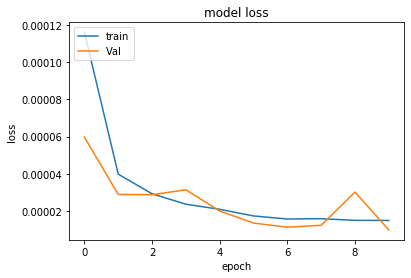

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [25]:
#model.save("model1_waterflow_mse_32.hdf5")

In [39]:
predicted_y_values = merged.predict(X_Test)

In [40]:
predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)

In [44]:
predicted_y_values_unnor[300]

array([-0.69835365, -0.18076596], dtype=float32)

In [45]:
#dataframe for output test labels
out_dataframe = pd.DataFrame(predicted_y_values_unnor, columns = ['t+1', 't+2'])

In [48]:
#original test labels dataframe
original_test_df = pd.DataFrame(Y_test_actual, columns = ['t+1', 't+2'])

In [46]:
out_dataframe

,t+1,t+2
0,-0.480194,0.010081
1,-0.460703,0.027132
2,-0.424516,0.058788
3,-0.367066,0.109046
4,-0.372851,0.103985
...,...,...
37086,19.968254,22.466238
37087,20.657249,22.946276
37088,18.373739,18.421289
37089,19.521666,20.539480


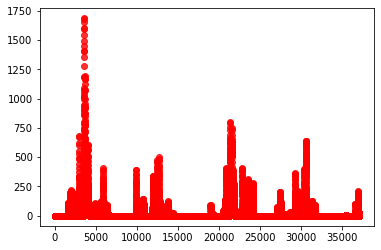

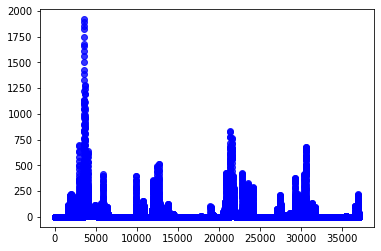

In [50]:
plt.figure()
plt.plot(out_dataframe['t+1'], 'ro', alpha=0.8)
plt.show()
plt.figure()
plt.plot(original_test_df['t+1'], 'bo', alpha=0.8)
plt.show()

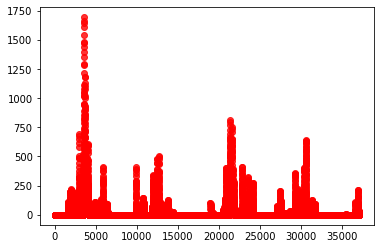

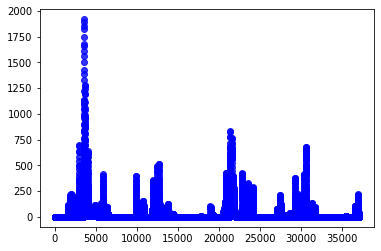

In [51]:
plt.figure()
plt.plot(out_dataframe['t+2'], 'ro', alpha=0.8)
plt.show()
plt.figure()
plt.plot(original_test_df['t+2'], 'bo', alpha=0.8)
plt.show()

In [52]:
merged.save("common_ffnetwork.hdf5")

In [29]:
max(predicted_y_values_unnor)

array([1648.8735], dtype=float32)

In [54]:
out_dataframe['t+1'].values

array([-0.48019445, -0.4607031 , -0.42451572, ..., 18.37374   ,
       19.521666  , 18.63187   ], dtype=float32)

In [30]:
#len(Y_test_actual)

37091

In [31]:
#len(predicted_y_values_unnor)

37091

In [32]:
#y_train_predict = model.predict(X_Train)
#predicted_y_train_unnor = ytrain_min_max_scaler.inverse_transform(y_train_predict)

In [33]:
#accuracy for test set
#l = len(predicted_y_values_unnor)
#acc = sum([np.round(predicted_y_values_unnor[i])==Y_test_actual[i] for i in range(l)])/l
#acc

array([0.256693])

In [55]:
#mean square error for day1
mean_square_root_day1 = mean_squared_error(out_dataframe['t+1'].values, original_test_df['t+1'])
mean_square_root_day1

46.479585851769635

In [56]:
#mean square error for day2
mean_square_root_day2 = mean_squared_error(out_dataframe['t+2'].values, original_test_df['t+2'])
mean_square_root_day2

87.2844564461952

In [36]:
#l = len(predicted_y_values)
#acc = sum([np.round(predicted_y_values[i])==Y_Test[i] for i in range(l)])/l
#acc

array([0.37095252])

In [37]:
# checking mse for test set that are greater than threshold
threshold = 250
timesteps = 18
test_values_above_thres = []
test_labels_above_theres = []

for i in range(timesteps, x_test.shape[0]):
    if (y_test[i] > threshold):
        test_values_above_thres.append(x_test[i-timesteps:i])
        test_labels_above_theres.append(y_test[i]) 
        
X_test_abv_thres = np.array(test_values_above_thres)
Y_test_abv_thres = np.array(test_labels_above_theres)

tsamples, ta, tb = X_test_abv_thres.shape
x_test_for_normalization = X_test_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
x_test_for_normalization.shape

X_Test_abv_thres = xtest_min_max_scaler.fit_transform(x_test_for_normalization)
Y_Test_abv_thres = ytest_min_max_scaler.fit_transform(Y_test_abv_thres)

X_Test_abv_thres = X_Test_abv_thres.reshape((tsamples, ta, tb))

In [38]:
predicted_y_test_abv_thres = model.predict(X_Test_abv_thres)
predicted_y_test_abv_thres_unnor = ytest_min_max_scaler.inverse_transform(predicted_y_test_abv_thres)
mean_square_root_abv_thres = mean_squared_error(predicted_y_test_abv_thres, Y_test_abv_thres)
mean_square_root_abv_thres

299535.30953529297